In [1]:
import scipy.io
import pandas as pd
import numpy as np

from math import log2
from dataclasses import dataclass, field

from functools import partial
from queue import deque
from enum import Enum
from collections import deque

from typing import *
from operator import *

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.datasets import *

import graphviz
#mat = scipy.io.loadmat('/Users/scott/projects/research-projects/tree_diff/input/twitter/influenza_outbreak_dataset.mat')

## Decision Tree Features
* ~Handle multiclass/binary~
* Binary or multple splits: Binary only 
* Choice of stopping criteria
* Choice of evaluation measure 
* Choice of splitting criteria 
* Choice of pruning strategy 
* Opaque rules

In [2]:
a = load_iris()
X = a.data
y = a.target

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.5)

# Simple Decision tree

## Data classes 

In [3]:
class Operator(str, Enum):
    EQ = "=="
    LT = "<"
    GT = ">"
    LE = "<="
    GE = ">="
    NE = "!="
    
    @property
    def op(self):
        return {self.EQ: eq, 
                self.LT: lt, 
                self.LE: le, 
                self.GE: ge,
                self.NE: ne,                
                self.GT: gt}[self]

@dataclass
class Condition:
    attribute: str
    attribute_pos: int
    operator: Operator
    threshold: float

    def __repr__(self):
        return str(self)

    def __str__(self):
        return f"{self.attribute} {self.operator} {self.threshold}"
            
    def fire(self, x):        
        return self.operator.op(x[self.attribute_pos], self.threshold)
    
@dataclass
class Split:
    score: float 
    attribute_pos: int
    ids: Tuple[float]
    operations: List[Tuple[Operator, float]]
        
@dataclass            
class DecisionNode:
    label: str
    node_id: int
    value: List[int]    
    impurity: float = 0.0
    parent: 'Node' = None
    children: List['Node'] = field(default_factory=list)
    conditions: List[Condition] = field(default_factory=list)    
        
    def walk(self, callback):
        callback(self)
        for n in self.children:
            n.walk(callback)        
        
    def add_child(self, condition, node):
        self.conditions.append(condition)
        node.parent = self
        self.children.append(node)
    
    def predict(self, x):
        stack = deque()
        stack.append(self)
        node = self

        while not node.is_leaf():
            node = stack.pop()

            for i, cond in enumerate(node.conditions):
                if cond.fire(x):
                    stack.append(node.children[i])

        return node.label            
    
    def is_leaf(self):
        return not self.children
    
    def is_root(self):
        return not self.parent
    
    def plot(self):
        dot = graphviz.Digraph('tree', comment='Decision Tree')  

        def update_dot(dot, node):
            dot.node(f"{node.node_id}", f"Node_{node.node_id}\nImpurity: {node.impurity:0.3f}\nLabel: {node.label}\nValue: {node.value}\nSamples: {sum(node.value)}")
            if node.parent:
                cond = node.find_to_condition()
                dot.edge(f"{node.parent.node_id}" , f"{node.node_id}", str(cond))
        
        update_dot_partial = partial(update_dot, dot)        
        self.walk(update_dot_partial)
        return dot
    
    def find_to_condition(self):
        if self.is_root():
            return None
        else:            
            index = -1
            for i, node in enumerate(self.parent.children):
                if node.node_id == self.node_id:
                    index = i
            if index < 0:
                raise ValueError("Incorrect tree")
            return self.parent.conditions[index]
                             
    def __str__(self):
        return f"Node_{self.node_id}"     
    
    def get_feature(self):
        if not self.is_leaf():
            return (self.conditions[0].attribute, self.conditions[0].attribute_pos)
    
    def get_nodes(self):
        node_list = []
        self.walk(lambda n: node_list.append(n))
        return node_list
    
    def get_leaves(self):
        leaf_list = []
        
        def check_leaf(n):
            if n.is_leaf():
                leaf_list.append(n)
        
        self.walk(check_leaf)
        return leaf_list
    
    def get_features(self):
        # returns list of tuples of (attribute, attribute_pos)
        l = []
        for n in self.get_nodes():
            feature = n.get_feature()
            if feature is not None:
                l.append(feature)
        return list(set(l))

    def get_root_node(self):
        n = self
        while not n.is_root():
            n = n.parent
        return n
    

In [4]:
lt(3,4)

True

In [5]:
node = DecisionNode(
    label = 'Root',
    node_id = 101,
    value = [500,100],    
    impurity = 0.23,
    parent = None,
    children = [],
    conditions=[Condition("height", 0, Operator.LT, 2.0)]
)        

In [6]:
node.is_root()

True

In [7]:
node2 = DecisionNode(
    label = 'Root',
    node_id = 102,
    value = [500,100],    
    impurity = 0.23,
    parent = node,
    children = [],
    conditions=[Condition("age", 1, Operator.LT, 60)]
)    

In [8]:
node.children = [node2]

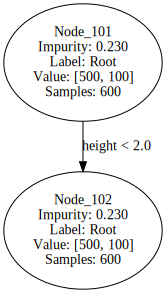

In [9]:
node.plot()

## Utility functions

In [10]:
def stopping_criteria(tree_depth, **kwargs):
    max_depth = kwargs.pop('max_depth', -1)
    if tree_depth >= max_depth:
        return True        
    return False    


def gini_impurity(y):
    counts = Counter(y)
    total = sum(counts.values())
    return round(1 - sum(map(lambda x: (x / total) ** 2, counts.values())), 3)


def entropy_impurity(y):
    counts = Counter(y)
    total = sum(counts.values())
    return - sum(map(lambda x: (x / total) * log2 (x / total), counts.values()))    
    

def evaluation_measure(groups: Tuple, measure):
    N = sum(map(len,groups))    
    return sum(map(lambda x: len(x) / N * measure(x), groups))
    
    
def calculate_current_depth(current_node):
    depth_counter = 0
    parent_node = current_node.parent    
    while parent_node:
        depth_counter += 1
        parent_node = parent_node.parent
    return depth_counter

def count_values(array, values):
    return [np.count_nonzero(array == i) for i in sorted(values)]        
        
def find_best_split(X, y, **kwargs):     
    split = Split(1,-1,(),())    
    measure = kwargs.pop("measure", gini_impurity)
    
    # Loop over attributes
    for i in range(0, X.shape[1]):
        x_s = X[:, i]

        # Try each unique value (inefficient for numerical values)
        # TODO: All split conditions are in the dataset unlike in CART       
        for threshold in np.unique(x_s):
            
            # TODO: Support non binary splits
            ids = (x_s <= threshold, x_s > threshold)
            operations = [(Operator.LE, threshold), (Operator.GT, threshold)]
            
            y_values = [y[i] for i in ids]            
            score = evaluation_measure(y_values, measure)

            # Find smallest gain, use 
            if score < split.score:
                split = Split(score, i, ids, operations)

    return split

## Grow a decision tree

In [11]:
def grow_tree(X, y, **kwargs):
    attribute_types = list(map(str, X.dtypes))
    column_name = X.columns
    X = X.to_numpy()
    node_counter = 1    
    stack = deque()
    
    # Set up decision tree
    classes = np.unique(y)
    counts = count_values(y, classes)
    tree = DecisionNode(max(y), node_counter, counts, gini_impurity(y))
    stack.append((tree, X, y))

    while len(stack) != 0:
        current_node, parent_X, parent_y = stack.pop()            

        # Stop once reached max depth branching
        current_depth = calculate_current_depth(current_node)
        if stopping_criteria(current_depth, **kwargs):
            continue
        
        # Stop branching if node contains a single class
        values = np.unique(parent_y)            
        if len(values) < 2:
            continue
        
        
        # Determine best attribute and split
        split = find_best_split(parent_X, parent_y, **kwargs)

        # Update tree with new split
        for cond, split_ids in zip(split.operations, split.ids):        
            new_y = parent_y[split_ids]
            new_X = parent_X[split_ids]            

            # Ensure new node is processed later
            counts = count_values(new_y, classes)
            if len(counts) == 0:
                continue 
            
            condition = Condition(column_name[split.attribute_pos], 
                                  split.attribute_pos, 
                                  cond[0],
                                  cond[1])
             
            label = classes[np.argmax(counts)]
            node_counter += 1
            
            score = gini_impurity(new_y)
 
            new_node = DecisionNode(label, node_counter, counts, score)
            current_node.add_child(condition, new_node)

            stack.append((new_node, new_X, new_y))
            
    return tree        
tree = grow_tree(pd.DataFrame(X_train, columns=["F1", "F2", "F3", 'F4']), y_train, max_depth=2, min_samples_split=2)
#tree.plot()

# Sample datasets

In [12]:
datasets = [load_iris, load_breast_cancer, load_digits, load_wine]

for func_data in datasets:
    d = func_data()
    X = d.data
    y = d.target
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.5)
    
    tree = grow_tree(pd.DataFrame(X_train), y_train, max_depth=2)            
    y_pred_cust = [tree.predict(X_test[i]) for i in range(0, X_test.shape[0])]
    
    sklearn_dt = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)    
    y_pred = sklearn_dt.predict(X_test)
    
    print(f"Sklearn Decision Tree:{accuracy_score(y_test, y_pred):0.2f}, Custom Tree:{accuracy_score(y_test, y_pred_cust):0.2f}, {func_data.__name__}")
    

Sklearn Decision Tree:0.96, Custom Tree:0.93, load_iris
Sklearn Decision Tree:0.93, Custom Tree:0.93, load_breast_cancer
Sklearn Decision Tree:0.31, Custom Tree:0.31, load_digits
Sklearn Decision Tree:0.87, Custom Tree:0.88, load_wine


# Regrowth algorithm

In [13]:
d = load_digits()
X = d.data
y = d.target
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.5)

tree = grow_tree(pd.DataFrame(X_train), y_train, max_depth=3)            
y_pred_cust_train = [tree.predict(X_train[i]) for i in range(0, X_train.shape[0])]
y_pred_cust = [tree.predict(X_test[i]) for i in range(0, X_test.shape[0])]

f"Train: {accuracy_score(y_train, y_pred_cust_train):0.2f}, Validation: {accuracy_score(y_test, y_pred_cust):0.2f}" 

'Train: 0.48, Validation: 0.45'

In [14]:
budget = 5
base_accuracy = accuracy_score(y_train, y_pred_cust_train)
base_tree = tree

leafs = []
tree.walk(lambda x: leafs.append(x))
N = sum(tree.value)
for x in sorted(leafs, key=lambda x: x.impurity, reverse=False):
    print(x.node_id, x.impurity, x.label, x.value, sum(x.value)/N)

13 0.0 0 [91, 0, 0, 0, 0, 0, 0, 0, 0, 0] 0.10133630289532294
11 0.169 0 [91, 0, 1, 0, 2, 2, 4, 0, 0, 0] 0.111358574610245
14 0.184 9 [0, 0, 0, 1, 0, 2, 0, 0, 0, 27] 0.0334075723830735
8 0.296 7 [0, 2, 1, 4, 1, 3, 0, 61, 1, 0] 0.08129175946547884
15 0.34 5 [1, 0, 1, 0, 0, 8, 0, 0, 0, 0] 0.011135857461024499
10 0.48 9 [1, 0, 1, 1, 0, 10, 0, 0, 0, 27] 0.044543429844097995
2 0.522 0 [92, 0, 2, 1, 2, 12, 4, 0, 0, 27] 0.155902004454343
6 0.641 6 [0, 6, 1, 2, 20, 66, 81, 0, 2, 0] 0.19821826280623608
12 0.691 6 [0, 0, 1, 0, 2, 2, 4, 0, 0, 0] 0.01002227171492205
7 0.773 4 [2, 33, 0, 2, 67, 4, 3, 9, 30, 46] 0.2182628062360802
9 0.787 3 [0, 43, 89, 90, 3, 1, 11, 7, 45, 22] 0.3463251670378619
4 0.821 3 [0, 45, 90, 94, 4, 4, 11, 68, 46, 22] 0.42761692650334077
5 0.826 4 [2, 39, 1, 4, 87, 70, 84, 9, 32, 46] 0.41648106904231624
3 0.888 3 [2, 84, 91, 98, 91, 74, 95, 77, 78, 68] 0.844097995545657
1 0.899 9 [94, 84, 93, 99, 93, 86, 99, 77, 78, 95] 1.0


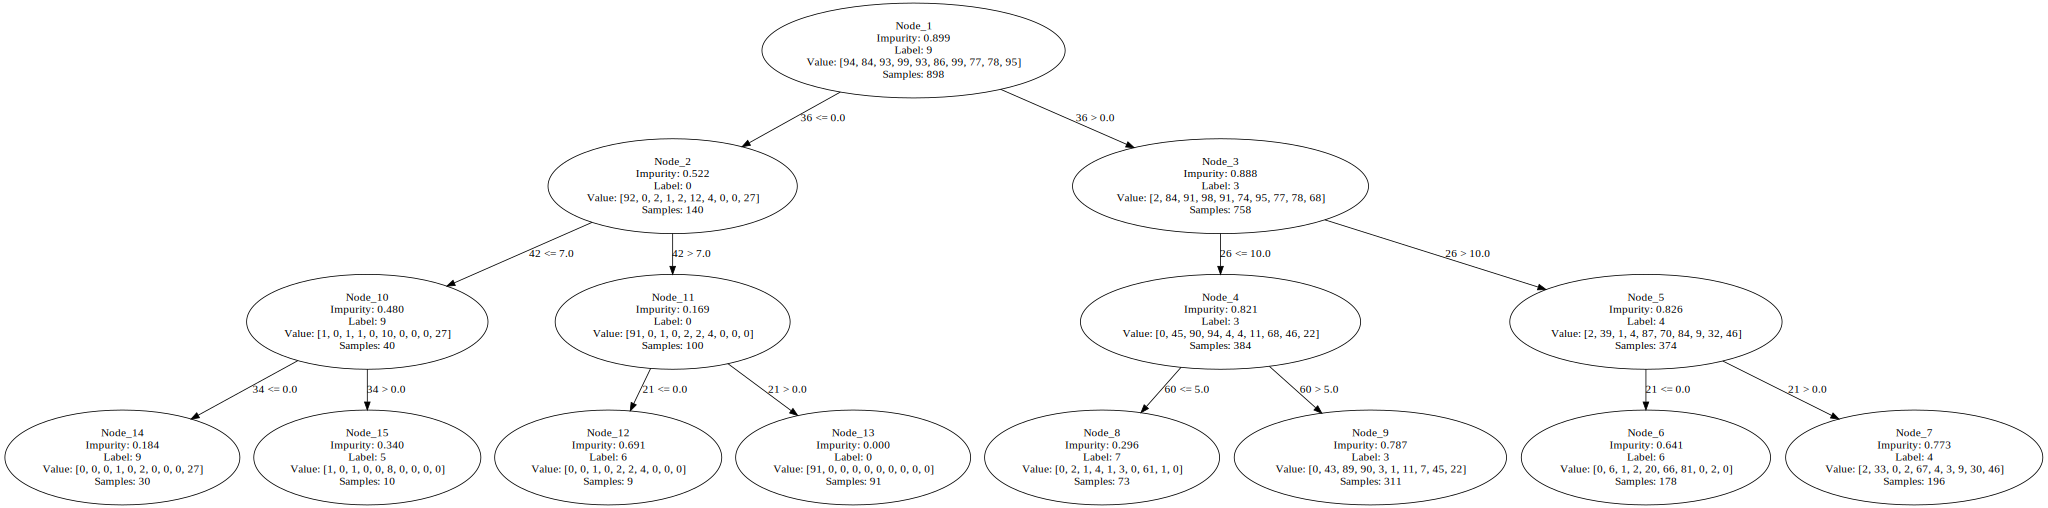

In [15]:
tree.plot()

In [16]:
len(tree.get_leaves())

8

In [17]:
tree.get_features()

[(36, 36), (26, 26), (21, 21), (34, 34), (60, 60), (42, 42)]

In [18]:
tree.conditions[0].attribute

36

In [19]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

In [20]:
X

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [21]:
from sklearn import datasets


In [22]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [23]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [24]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [25]:

@dataclass
class BCondition:
    attribute: str
    attribute_pos: int
    #operator: Operator
    lowerbracket_open: bool
    lowerthreshold: float
    upperthreshold: float    
    upperbracket_open: bool    
        
    
    #threshold: float

    def __repr__(self):
        return str(self)

    def __str__(self):
        if self.lowerbracket_open:
            lowerbracket = "("
        else:
            lowerbracket = "["
        if self.upperbracket_open:
            upperbracket = ")"
        else:
            upperbracket = "]"
        
        return f"{self.attribute} ∈ {lowerbracket}{self.lowerthreshold}, {self.upperthreshold}{upperbracket}"
            
    def fire(self, x):        
        attribute_val = x[self.attribute_pos]
        # return true if attribute_val between lower and upper bound
    

@dataclass
class DecisionBoundary:
    label: str
    value: List[int]  
    conditions: List[BCondition]     
        
        
        
@dataclass
class DecisionSpace:
    boundaries: List[DecisionBoundary]

In [26]:
boundary1 = DecisionBoundary(label = 'A', 
                            value = [80,20],
                            conditions = [BCondition("Age",1, False,1,3,False ),BCondition("Height",2,True,160,178,False)]
                            )

boundary2 = DecisionBoundary(label = 'B', 
                            value = [80,20],
                            conditions = [BCondition("Age",1, False,1,3,False ),BCondition("Height",2,True,160,178,False)]
                            )

In [27]:
space = DecisionSpace([boundary1,boundary2])

In [28]:
print(space)

DecisionSpace(boundaries=[DecisionBoundary(label='A', value=[80, 20], conditions=[Age ∈ [1, 3], Height ∈ (160, 178]]), DecisionBoundary(label='B', value=[80, 20], conditions=[Age ∈ [1, 3], Height ∈ (160, 178]])])


In [29]:
def get_decisionspace(tree, boundary_conditions = []):
    leaves = tree.get_leaves()
    boundaries = []
        
    for l in leaves:
        boundaries.append(get_decisionboundary(l, boundary_conditions))
    return DecisionSpace(boundaries )      
            
def get_leaf_condition(leaf):
    condi = []
    p = leaf
    while p is not None:
        p_cond = p.find_to_condition()
        if p_cond is not None:
            condi.append(p_cond)
        p = p.parent 
    return condi


def get_decisionboundary(leaf, boundary_conditions):
    bound_condi = []
    for f, f_pos in leaf.get_root_node().get_features():
        feature_min_upper_bound = float('inf')
        feature_max_lower_bound = float('-inf')
        for c in get_leaf_condition(leaf) + boundary_conditions:
            if c.attribute == f:
                if c.operator == Operator.LE:
                    if feature_min_upper_bound > c.threshold:
                        feature_min_upper_bound = c.threshold
                if c.operator == Operator.GT:
                    if feature_max_lower_bound < c.threshold:
                        feature_max_lower_bound = c.threshold
                    
        #BCondition(f,f_pos,True,feature_max_lower_bound,feature_min_upper_bound,False)
        bound_condi.append(BCondition(f,f_pos,True,feature_max_lower_bound,feature_min_upper_bound,False))   
    # TODO: get list of rules for leaf and convert to a decision boundary
    decision_boundary = DecisionBoundary(label = leaf.label, value = leaf.value, conditions = bound_condi )
    return decision_boundary

def specialization(boundary: DecisionBoundary  ):
    a = 0
    for condition in boundary.conditions:
        a +=  (condition.upperthreshold -  condition.lowerthreshold)
    return a/len(boundary.conditions)    

def merge_value(boundary_x: DecisionBoundary, boundary_y: DecisionBoundary):
    weight_x = specialization(boundary_x)/(specialization(boundary_x)+specialization(boundary_y))
    weight_y = specialization(boundary_y)/(specialization(boundary_x)+specialization(boundary_y))
    value_x = np.array(boundary_x.value)
    value_y = np.array(boundary_y.value)
    value_z = value_x * weight_x + value_y * weight_y
    
    return value_z

def check_intersect(b1: BCondition, b2: BCondition):
    assert b1.attribute == b2.attribute

    return (
        (b1.lowerthreshold <= b2.lowerthreshold and b2.lowerthreshold <= b1.upperthreshold) or 
        (b1.lowerthreshold <= b2.upperthreshold and b2.upperthreshold <= b1.upperthreshold) or 
        (b2.lowerthreshold <= b1.lowerthreshold and b1.lowerthreshold <= b2.upperthreshold) or
        (b2.lowerthreshold <= b1.upperthreshold and b1.upperthreshold <= b2.upperthreshold)
    ) 
        

        
def check_intersect_boundary(boundary_x: DecisionBoundary, boundary_y: DecisionBoundary):
    for b_x in boundary_x.conditions:
        for b_y in boundary_y.conditions:
            if b_x.attribute == b_y.attribute:
                if not check_intersect(b_x , b_y):
                    return False
    return True
        


def intersect_thres(b1: BCondition, b2:BCondition):
    assert b1.attribute == b2.attribute
    
    maxlowerbound = max(b1.lowerthreshold, b2.lowerthreshold)
    minupperbound = min(b1.upperthreshold, b2.upperthreshold)
    assert maxlowerbound <= minupperbound
    
    return BCondition(b1.attribute,b1.attribute_pos, True, maxlowerbound, minupperbound, False)
        
        
def boundary_intersection(boundary_x: DecisionBoundary, boundary_y: DecisionBoundary):
    if not check_intersect_boundary(boundary_x, boundary_y):
        return None
    
    conditions = []
    for b_x in boundary_x.conditions:
        for b_y in boundary_y.conditions: 
            if b_x.attribute == b_y.attribute:
                condition = intersect_thres(b_x , b_y)
                conditions.append(condition)
    return DecisionBoundary(boundary_x.label+ boundary_y.label, merge_value(boundary_x, boundary_y), conditions)
    

def merge_decision_space(X, Y):
    Z = []
    for boundary_x in X.boundaries:
        for boundary_y in Y.boundaries:
            intersection = boundary_intersection(boundary_x, boundary_y)
            if intersection is not None:
                Z.append(intersection)
    return DecisionSpace(Z)


In [30]:
example_leaf = tree.get_leaves()[0]

In [31]:
get_leaf_condition(example_leaf)

[34 <= 0.0, 42 <= 7.0, 36 <= 0.0]

In [32]:
example_leaf.get_root_node().get_features()

[(36, 36), (26, 26), (21, 21), (34, 34), (60, 60), (42, 42)]

In [33]:
example_leaf.get_features()

[]

In [34]:
#get_decisionboundary(example_leaf)

In [35]:
get_decisionspace(tree).boundaries

[DecisionBoundary(label=9, value=[0, 0, 0, 1, 0, 2, 0, 0, 0, 27], conditions=[36 ∈ (-inf, 0.0], 26 ∈ (-inf, inf], 21 ∈ (-inf, inf], 34 ∈ (-inf, 0.0], 60 ∈ (-inf, inf], 42 ∈ (-inf, 7.0]]),
 DecisionBoundary(label=5, value=[1, 0, 1, 0, 0, 8, 0, 0, 0, 0], conditions=[36 ∈ (-inf, 0.0], 26 ∈ (-inf, inf], 21 ∈ (-inf, inf], 34 ∈ (0.0, inf], 60 ∈ (-inf, inf], 42 ∈ (-inf, 7.0]]),
 DecisionBoundary(label=6, value=[0, 0, 1, 0, 2, 2, 4, 0, 0, 0], conditions=[36 ∈ (-inf, 0.0], 26 ∈ (-inf, inf], 21 ∈ (-inf, 0.0], 34 ∈ (-inf, inf], 60 ∈ (-inf, inf], 42 ∈ (7.0, inf]]),
 DecisionBoundary(label=0, value=[91, 0, 0, 0, 0, 0, 0, 0, 0, 0], conditions=[36 ∈ (-inf, 0.0], 26 ∈ (-inf, inf], 21 ∈ (0.0, inf], 34 ∈ (-inf, inf], 60 ∈ (-inf, inf], 42 ∈ (7.0, inf]]),
 DecisionBoundary(label=7, value=[0, 2, 1, 4, 1, 3, 0, 61, 1, 0], conditions=[36 ∈ (0.0, inf], 26 ∈ (-inf, 10.0], 21 ∈ (-inf, inf], 34 ∈ (-inf, inf], 60 ∈ (-inf, 5.0], 42 ∈ (-inf, inf]]),
 DecisionBoundary(label=3, value=[0, 43, 89, 90, 3, 1, 11, 7, 45, 

In [36]:
def data_to_decisionspace(X, y):
    tree = grow_tree(X,y,max_depth = 2, min_samples_split = 2)
    space = get_decisionspace(tree)
    return space 
    

In [37]:
d = load_iris()
data_to_decisionspace(pd.DataFrame(d.data, columns=d.feature_names), d.target)

DecisionSpace(boundaries=[DecisionBoundary(label=0, value=[50, 0, 0], conditions=[petal length (cm) ∈ (-inf, 1.9], petal width (cm) ∈ (-inf, inf]]), DecisionBoundary(label=1, value=[0, 49, 5], conditions=[petal length (cm) ∈ (1.9, inf], petal width (cm) ∈ (-inf, 1.7]]), DecisionBoundary(label=2, value=[0, 1, 45], conditions=[petal length (cm) ∈ (1.9, inf], petal width (cm) ∈ (1.7, inf]])])

In [38]:
d.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [39]:
d.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [40]:
boundary3 = DecisionBoundary(label = 'A', 
                            value = [75,25],
                            conditions = [BCondition("Age",0, False,0,5,True ),BCondition("Degree",1,False,0,3,True)]
                            )

boundary4 = DecisionBoundary(label = 'B', 
                            value = [100,0],
                            conditions = [BCondition("Age",1, False,0,7,True ),BCondition("Degree",2,False,0,5,True)]
                            )

In [41]:
merge_value(boundary3, boundary4)

array([90., 10.])

In [42]:
boundaryA11 = DecisionBoundary(label = 'A11', 
                            value = [75,25],
                            conditions = [BCondition("Age",0, False,0,5,True ),BCondition("Degree",1,False,0,3,True)]
                            )

boundaryA12 = DecisionBoundary(label = 'A12', 
                            value = [20,80],
                            conditions = [BCondition("Age",0, False,5,8,False ),BCondition("Degree",1,False,0,3,True)]
                            )

boundaryA22 = DecisionBoundary(label = 'A22', 
                            value = [40,60],
                            conditions = [BCondition("Age",0, False,0,8,False ),BCondition("Degree",1,False,3,10,True)]
                            )

boundaryA23 = DecisionBoundary(label = 'A23', 
                            value = [100,0],
                            conditions = [BCondition("Age",0, False,0,8,False ),BCondition("Degree",1,False,10,15,False)]
                            )

DSA = DecisionSpace([boundaryA11, boundaryA12, boundaryA22, boundaryA23])


In [43]:
boundaryB11 = DecisionBoundary(label = 'B11', 
                            value = [100,0],
                            conditions = [BCondition("Age",0, False,0,7,True ),BCondition("Degree",1,False,0,5,True)]
                            )

boundaryB12 = DecisionBoundary(label = 'B12', 
                            value = [0,100],
                            conditions = [BCondition("Age",0, False,7,9,False ),BCondition("Degree",1,False,0,11,False)]
                            )

boundaryB22 = DecisionBoundary(label = 'B22', 
                            value = [25,75],
                            conditions = [BCondition("Age",0, False,0,7,True ),BCondition("Degree",1,False,5,11,False)]
                            )



DSB = DecisionSpace([boundaryB11, boundaryB12, boundaryB22])


In [44]:
DSC = merge_decision_space(DSA, DSB)

In [45]:
def pretty_print(decision_space):
    for boundary in decision_space.boundaries:
        print(boundary.label, boundary.value, boundary.conditions)

In [46]:
pretty_print(DSC)

A11B11 [90. 10.] [Age ∈ (0, 5], Degree ∈ (0, 3]]
A12B11 [73.33333333 26.66666667] [Age ∈ (5, 7], Degree ∈ (0, 3]]
A12B12 [ 6.31578947 93.68421053] [Age ∈ (7, 8], Degree ∈ (0, 3]]
A22B11 [66.66666667 33.33333333] [Age ∈ (0, 7], Degree ∈ (3, 5]]
A22B12 [21.42857143 78.57142857] [Age ∈ (7, 8], Degree ∈ (3, 10]]
A22B22 [33.03571429 66.96428571] [Age ∈ (0, 7], Degree ∈ (5, 10]]
A23B12 [50. 50.] [Age ∈ (7, 8], Degree ∈ (10, 11]]
A23B22 [62.5 37.5] [Age ∈ (0, 7], Degree ∈ (10, 11]]


In [47]:
pretty_print(DSA)

A11 [75, 25] [Age ∈ [0, 5), Degree ∈ [0, 3)]
A12 [20, 80] [Age ∈ [5, 8], Degree ∈ [0, 3)]
A22 [40, 60] [Age ∈ [0, 8], Degree ∈ [3, 10)]
A23 [100, 0] [Age ∈ [0, 8], Degree ∈ [10, 15]]


In [48]:
pretty_print(DSB)

B11 [100, 0] [Age ∈ [0, 7), Degree ∈ [0, 5)]
B12 [0, 100] [Age ∈ [7, 9], Degree ∈ [0, 11]]
B22 [25, 75] [Age ∈ [0, 7), Degree ∈ [5, 11]]


In [49]:
merge_value(boundaryA12, boundaryB12)

array([ 6.31578947, 93.68421053])

In [50]:
merge_value(boundaryA22, boundaryB12)

array([21.42857143, 78.57142857])

In [51]:
print(check_intersect_boundary(boundaryA22, boundaryB12))

True


In [52]:
print(check_intersect_boundary(boundaryB12, boundaryA22))

True


In [53]:
from sklearn.datasets import load_iris
import random
iris = load_iris()
X, y = iris.data, iris.target

# Shuffle dataset
random.seed(2)
idx = random.sample(list(range(0,len(X))), k=len(X))
X = X[idx]
y = y[idx]

# batch 1
X1, y1 = X[:len(X) // 2], y[:len(X) // 2]
# batch 2
X2, y2 = X[len(X) // 2:], y[:len(X) // 2:]

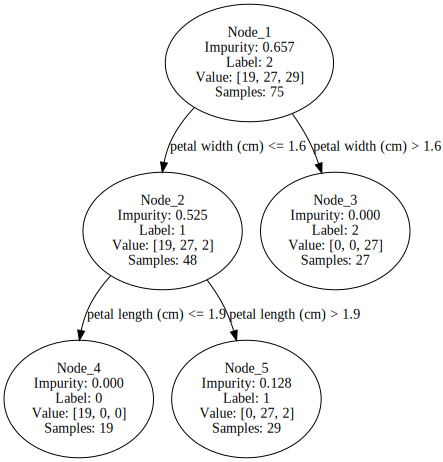

In [54]:
tree1 = grow_tree(
    pd.DataFrame(X1, columns=iris.feature_names),
    y1,
    max_depth = 2
)
tree1.plot()

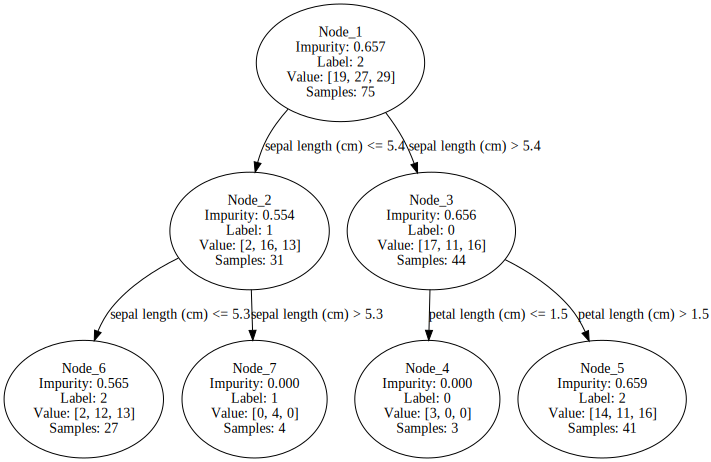

In [55]:
tree2 = grow_tree(
    pd.DataFrame(X2, columns=iris.feature_names),
    y2,
    max_depth = 2
)
tree2.plot()

In [56]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [57]:
boundary_conditions = [
    Condition("sepal length (cm)", 0, Operator.GT, 0),
    Condition("sepal length (cm)", 0, Operator.LE, 10),
    Condition("sepal width (cm)", 1, Operator.GT, 0),
    Condition("sepal width (cm)", 1, Operator.LE, 10),
    Condition("petal length (cm)", 2, Operator.GT, 0),
    Condition("petal length (cm)", 2, Operator.LE, 10),
    Condition("petal width (cm)", 3, Operator.GT, 0),    
    Condition("petal width (cm)", 3, Operator.LE, 10),    
]

In [58]:
DS1= get_decisionspace(tree1, boundary_conditions)

In [59]:
DS2= get_decisionspace(tree2, boundary_conditions)

In [60]:
DS1

DecisionSpace(boundaries=[DecisionBoundary(label=0, value=[19, 0, 0], conditions=[petal length (cm) ∈ (0, 1.9], petal width (cm) ∈ (0, 1.6]]), DecisionBoundary(label=1, value=[0, 27, 2], conditions=[petal length (cm) ∈ (1.9, 10], petal width (cm) ∈ (0, 1.6]]), DecisionBoundary(label=2, value=[0, 0, 27], conditions=[petal length (cm) ∈ (0, 10], petal width (cm) ∈ (1.6, 10]])])

In [61]:
DS2

DecisionSpace(boundaries=[DecisionBoundary(label=2, value=[2, 12, 13], conditions=[sepal length (cm) ∈ (0, 5.3], petal length (cm) ∈ (0, 10]]), DecisionBoundary(label=1, value=[0, 4, 0], conditions=[sepal length (cm) ∈ (5.3, 5.4], petal length (cm) ∈ (0, 10]]), DecisionBoundary(label=0, value=[3, 0, 0], conditions=[sepal length (cm) ∈ (5.4, 10], petal length (cm) ∈ (0, 1.5]]), DecisionBoundary(label=2, value=[14, 11, 16], conditions=[sepal length (cm) ∈ (5.4, 10], petal length (cm) ∈ (1.5, 10]])])

In [62]:
DS3 = merge_decision_space(DS1, DS2)

In [74]:
DS3

DecisionSpace(boundaries=[DecisionBoundary(label=2, value=array([ 5.16489362,  9.76595745, 10.57978723]), conditions=[petal length (cm) ∈ (0, 1.9]]), DecisionBoundary(label=1, value=array([4.88970588, 2.97058824, 0.        ]), conditions=[petal length (cm) ∈ (0, 1.9]]), DecisionBoundary(label=0, value=array([8.83333333, 0.        , 0.        ]), conditions=[petal length (cm) ∈ (0, 1.5]]), DecisionBoundary(label=2, value=array([15.05421687,  8.68072289, 12.62650602]), conditions=[petal length (cm) ∈ (1.5, 1.9]]), DecisionBoundary(label=3, value=array([ 1.224, 17.82 ,  8.732]), conditions=[petal length (cm) ∈ (1.9, 10]]), DecisionBoundary(label=2, value=array([ 0.        , 15.26767677,  0.97979798]), conditions=[petal length (cm) ∈ (1.9, 10]]), DecisionBoundary(label=3, value=array([ 8.04385965, 17.80701754, 10.04385965]), conditions=[petal length (cm) ∈ (1.9, 10]]), DecisionBoundary(label=4, value=array([ 0.90801187,  5.44807122, 20.64391691]), conditions=[petal length (cm) ∈ (0, 10]]),

In [63]:
pretty_print(DS3)

2 [ 5.16489362  9.76595745 10.57978723] [petal length (cm) ∈ (0, 1.9]]
1 [4.88970588 2.97058824 0.        ] [petal length (cm) ∈ (0, 1.9]]
0 [8.83333333 0.         0.        ] [petal length (cm) ∈ (0, 1.5]]
2 [15.05421687  8.68072289 12.62650602] [petal length (cm) ∈ (1.5, 1.9]]
3 [ 1.224 17.82   8.732] [petal length (cm) ∈ (1.9, 10]]
2 [ 0.         15.26767677  0.97979798] [petal length (cm) ∈ (1.9, 10]]
3 [ 8.04385965 17.80701754 10.04385965] [petal length (cm) ∈ (1.9, 10]]
4 [ 0.90801187  5.44807122 20.64391691] [petal length (cm) ∈ (0, 10]]
3 [ 0.          1.41754386 17.43157895] [petal length (cm) ∈ (0, 10]]
2 [ 0.74693878  0.         20.27755102] [petal length (cm) ∈ (0, 1.5]]
4 [ 5.82222222  4.57460317 22.42539683] [petal length (cm) ∈ (1.5, 10]]


# The following is prune Decision space. 

In [65]:
a = BCondition("a", 1, False, 3, 10, False)

In [66]:
a

a ∈ [3, 10]

In [67]:
b = BCondition("a", 1, False, 3, 10, False)

In [68]:
b

a ∈ [3, 10]

In [69]:
a == b

True

In [115]:
def check_adjacent_condition(b1: BCondition, b2: BCondition):
    assert b1.attribute == b2.attribute

    return (
        (b1.lowerthreshold == b2.upperthreshold) or 
        (b1.upperthreshold == b2.lowerthreshold)
    ) 
        
def adjacent(boundary_x: DecisionBoundary, boundary_y: DecisionBoundary):
    shared_boundaries = 0
    adjacent_boundaries = 0
    
    for b_x in boundary_x.conditions:
        for b_y in boundary_y.conditions:
            if b_x.attribute == b_y.attribute:
                if b_x == b_y:
                    shared_boundaries += 1
                elif check_adjacent_condition(b_x, b_y):
                    adjacent_boundaries += 1
                else:
                    # boundary is neither shared nor adjacent
                    return False
    
    if adjacent_boundaries == 1:
        assert shared_boundaries == len(boundary_x.conditions) - 1
        return True
    
    return False




def neighbour_check(X):
    Z = []
    for i, boundary_x in enumerate(X.boundaries):
        for j, boundary_y in enumerate(X.boundaries):
            if i == j:
                continue
            
            if adjacent(boundary_x, boundary_y):
                Z.append((boundary_x, boundary_y))
    return Z


def value_simcheck(boundary_x: DecisionBoundary, boundary_y: DecisionBoundary):
    dist = np.linalg.norm(boundary_x.value - boundary_y.value)
    return dist


def combine(boundary_x: DecisionBoundary, boundary_y: DecisionBoundary):
    new_conditions = []
    
    for b_x in boundary_x.conditions:
        for b_y in boundary_y.conditions:
            if b_x.attribute == b_y.attribute:
                if b_x == b_y:
                    new_conditions.append(b_x)
                else:
                    cond = BCondition(b_x.attribute, b_x.attribute_pos,True,
                              min(b_x.lowerthreshold, b_y.lowerthreshold),
                              max(b_x.upperthreshold, b_y.upperthreshold), False)
                    new_conditions.append(cond)
    
    new_boundary = DecisionBoundary(boundary_x.label + boundary_y.label,
                                    merge_value(boundary_x, boundary_y),
                                    new_conditions)
    return new_boundary


def prune_one(X, alpha=50.0):
    pairs = neighbour_check(X)
    sorted_pairs = sorted(pairs, key = lambda p: value_simcheck(p[0], p[1]))

    if not sorted_pairs:
        return None

    best_pair = sorted_pairs[0]
    x, y = best_pair
    
    if value_simcheck(x, y) > alpha:
        return None
    
    Y = X.boundaries.copy()
    Y.remove(x)
    Y.remove(y)
    Y.append(combine(x, y))
    
    return Y

def prune(X):
    while True:
        Y = prune_one(X)
        if Y is None:
            # no possible merges / merge didn't pass alpha check
            break
        X = DecisionSpace(Y)
    return X


In [116]:
DSC

DecisionSpace(boundaries=[DecisionBoundary(label='A11B11', value=array([90., 10.]), conditions=[Age ∈ (0, 5], Degree ∈ (0, 3]]), DecisionBoundary(label='A12B11', value=array([73.33333333, 26.66666667]), conditions=[Age ∈ (5, 7], Degree ∈ (0, 3]]), DecisionBoundary(label='A12B12', value=array([ 6.31578947, 93.68421053]), conditions=[Age ∈ (7, 8], Degree ∈ (0, 3]]), DecisionBoundary(label='A22B11', value=array([66.66666667, 33.33333333]), conditions=[Age ∈ (0, 7], Degree ∈ (3, 5]]), DecisionBoundary(label='A22B12', value=array([21.42857143, 78.57142857]), conditions=[Age ∈ (7, 8], Degree ∈ (3, 10]]), DecisionBoundary(label='A22B22', value=array([33.03571429, 66.96428571]), conditions=[Age ∈ (0, 7], Degree ∈ (5, 10]]), DecisionBoundary(label='A23B12', value=array([50., 50.]), conditions=[Age ∈ (7, 8], Degree ∈ (10, 11]]), DecisionBoundary(label='A23B22', value=array([62.5, 37.5]), conditions=[Age ∈ (0, 7], Degree ∈ (10, 11]])])

In [117]:
prune(DSC)

DecisionSpace(boundaries=[DecisionBoundary(label='A22B22', value=array([33.03571429, 66.96428571]), conditions=[Age ∈ (0, 7], Degree ∈ (5, 10]]), DecisionBoundary(label='A23B12A23B22', value=array([60., 40.]), conditions=[Age ∈ (0, 8], Degree ∈ (10, 11]]), DecisionBoundary(label='A12B12A22B12', value=array([16.39097744, 83.60902256]), conditions=[Age ∈ (7, 8], Degree ∈ (0, 10]]), DecisionBoundary(label='A22B11A11B11A12B11', value=array([75.57354926, 24.42645074]), conditions=[Age ∈ (0, 7], Degree ∈ (0, 5]])])

In [88]:
pairs = neighbour_check(DSC)
first_pair = pairs[0]
print("first pair", first_pair)
value_simcheck(first_pair[0], first_pair[1])

first pair (DecisionBoundary(label='A11B11', value=array([90., 10.]), conditions=[Age ∈ (0, 5], Degree ∈ (0, 3]]), DecisionBoundary(label='A12B11', value=array([73.33333333, 26.66666667]), conditions=[Age ∈ (5, 7], Degree ∈ (0, 3]]))


23.570226039551585

In [89]:
pairs

[(DecisionBoundary(label='A11B11', value=array([90., 10.]), conditions=[Age ∈ (0, 5], Degree ∈ (0, 3]]),
  DecisionBoundary(label='A12B11', value=array([73.33333333, 26.66666667]), conditions=[Age ∈ (5, 7], Degree ∈ (0, 3]])),
 (DecisionBoundary(label='A12B11', value=array([73.33333333, 26.66666667]), conditions=[Age ∈ (5, 7], Degree ∈ (0, 3]]),
  DecisionBoundary(label='A11B11', value=array([90., 10.]), conditions=[Age ∈ (0, 5], Degree ∈ (0, 3]])),
 (DecisionBoundary(label='A12B11', value=array([73.33333333, 26.66666667]), conditions=[Age ∈ (5, 7], Degree ∈ (0, 3]]),
  DecisionBoundary(label='A12B12', value=array([ 6.31578947, 93.68421053]), conditions=[Age ∈ (7, 8], Degree ∈ (0, 3]])),
 (DecisionBoundary(label='A12B12', value=array([ 6.31578947, 93.68421053]), conditions=[Age ∈ (7, 8], Degree ∈ (0, 3]]),
  DecisionBoundary(label='A12B11', value=array([73.33333333, 26.66666667]), conditions=[Age ∈ (5, 7], Degree ∈ (0, 3]])),
 (DecisionBoundary(label='A12B12', value=array([ 6.31578947,